<a href="https://colab.research.google.com/github/Gaurs86/ML-Assignments/blob/main/VAE_MNSIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Device setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [18]:
# -----------------------------
# Load MNIST dataset
# -----------------------------
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.01MB/s]


In [19]:
#-----------------------------
# Define VAE Model
# -----------------------------
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc2(z))
        return self.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [20]:
# -----------------------------
# Loss Function
# -----------------------------
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [21]:
# -----------------------------
# Training
# -----------------------------
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 10
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = vae(x)
        loss = loss_function(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 163.9553
Epoch 2, Loss: 121.1318
Epoch 3, Loss: 114.3836
Epoch 4, Loss: 111.4745
Epoch 5, Loss: 109.8087
Epoch 6, Loss: 108.6431
Epoch 7, Loss: 107.8037
Epoch 8, Loss: 107.1373
Epoch 9, Loss: 106.6278
Epoch 10, Loss: 106.2490


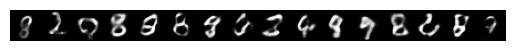

In [22]:
# -----------------------------
# Generate Samples
# -----------------------------
vae.eval()
with torch.no_grad():
    z = torch.randn(16, 20).to(device)
    sample = vae.decode(z).cpu()
    sample = sample.view(-1, 1, 28, 28)

# Show generated digits
grid_img = torch.cat([sample[i] for i in range(16)], dim=2).squeeze()
plt.imshow(grid_img, cmap="gray")
plt.axis("off")
plt.show()

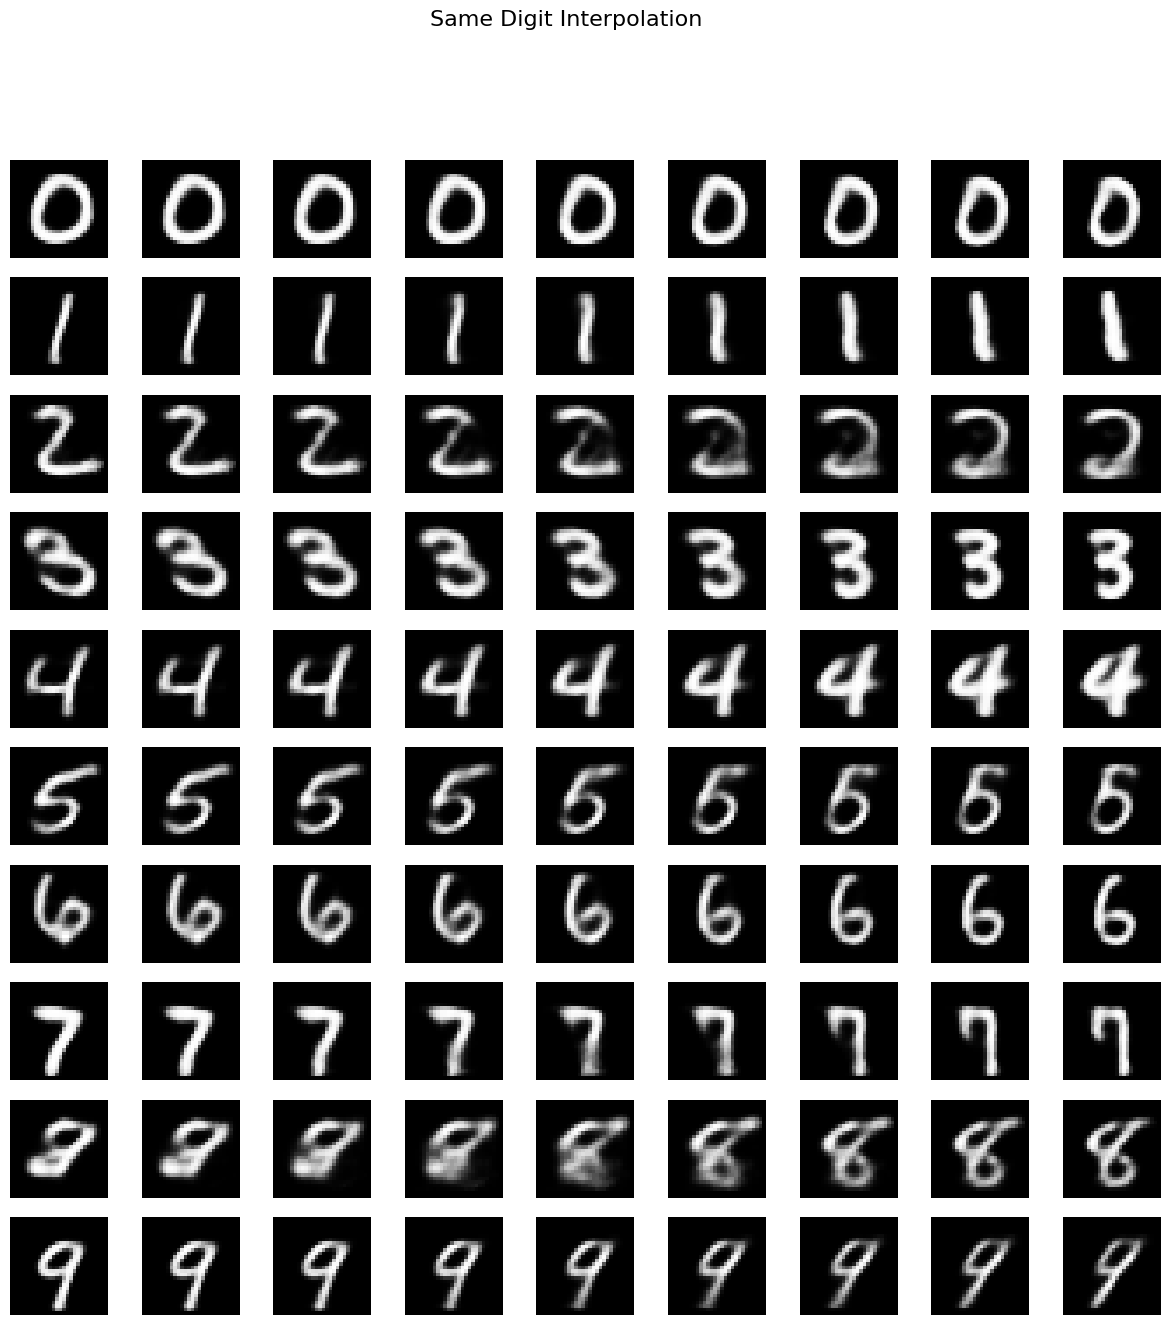

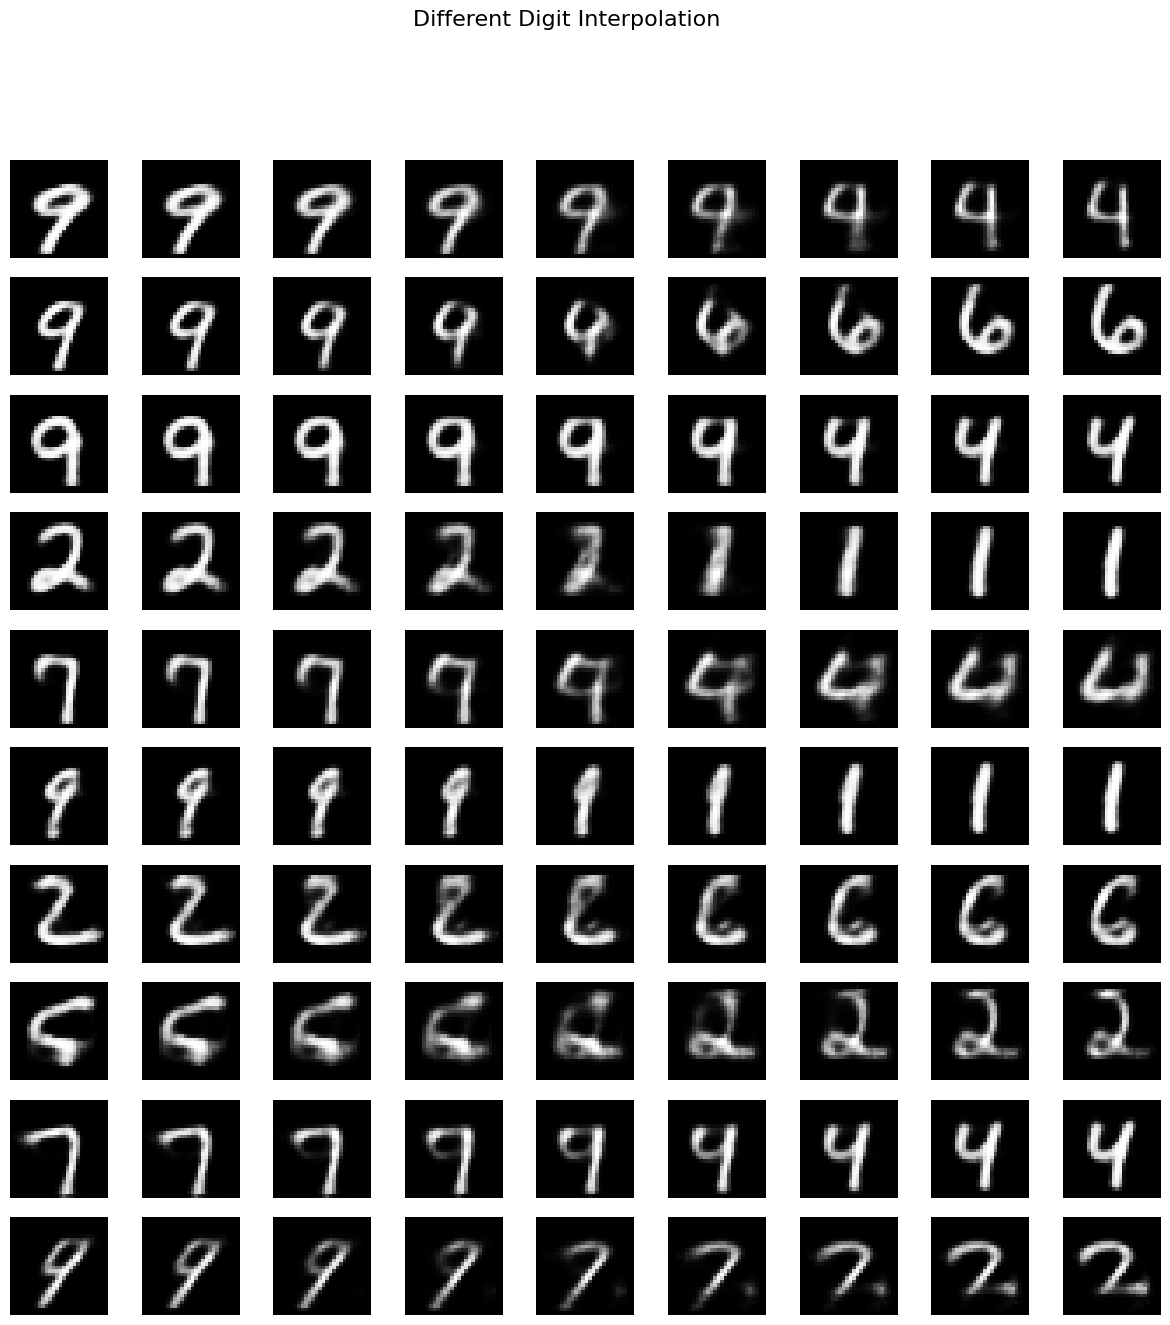

In [25]:
# Function: interpolate in latent space
def interpolate_images(img1, img2, vae, device, num_steps=7):
    vae.eval()
    with torch.no_grad():
        # Encode images -> latent mean
        mu1, _ = vae.encode(img1.view(-1, 28*28).to(device))
        mu2, _ = vae.encode(img2.view(-1, 28*28).to(device))

        # Interpolation weights
        alphas = torch.linspace(0, 1, num_steps+2).to(device)  # includes start & end

        # Linear interpolation in latent space
        interpolations = []
        for alpha in alphas:
            z = (1 - alpha) * mu1 + alpha * mu2
            recon = vae.decode(z).cpu().view(28, 28)
            interpolations.append(recon)

        return interpolations

# Function: plot interpolation grid
def plot_interpolations(pairs, vae, device, title="Interpolation"):
    fig, axes = plt.subplots(len(pairs), 9, figsize=(15, 15))
    for i, (img1, img2) in enumerate(pairs):
        images = interpolate_images(img1, img2, vae, device, num_steps=7)
        for j, img in enumerate(images):
            axes[i, j].imshow(img, cmap="gray")
            axes[i, j].axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# ---- Generate pairs ----
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)

# Convert labels to numpy for filtering
labels_np = test_labels.numpy()

# Same digit pairs
same_digit_pairs = []
for digit in range(10):
    idx = np.where(labels_np == digit)[0]
    choice = np.random.choice(idx, 2, replace=False)
    same_digit_pairs.append((test_images[choice[0]], test_images[choice[1]]))

# Different digit pairs
diff_digit_pairs = []
for _ in range(10):
    idx1, idx2 = np.random.choice(len(test_images), 2, replace=False)
    while test_labels[idx1] == test_labels[idx2]:  # ensure different
        idx2 = np.random.choice(len(test_images))
    diff_digit_pairs.append((test_images[idx1], test_images[idx2]))

# ---- Plot results ----
plot_interpolations(same_digit_pairs, vae, device, title="Same Digit Interpolation")
plot_interpolations(diff_digit_pairs, vae, device, title="Different Digit Interpolation")
